# Conformal Prediction for Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# Vector Graphics
%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Conformal Prediction Package
%pip install mapie
from mapie.classification import MapieClassifier

Note: you may need to restart the kernel to use updated packages.


<div align="justify">

Conformal prediction ({cite:t}`vovk_al,shaf_at08,bala_cp`) is a framework for reliable prediction that is rooted in classical frequentist statistics, more specifically in hypothesis testing[^revision].
Given a sequence of training observations and a new query $\vec{x}_{q}$ (which in the following plot is marked red) with unknown outcome $y_{N+1}$,

$$
(\vec{x}_1, y_1), \,  (\vec{x}_2, y_2), \ldots ,  (\vec{x}_N, y_N), \, (\vec{x}_{N+1}, \bullet)
\enspace ,
$$(cpseq)

</div>

[^revision]: If this concept is new to you we recommend visiting our site on Hypothesis Testing {doc}`../chapter-auxilary/hypothesis-excurs`.

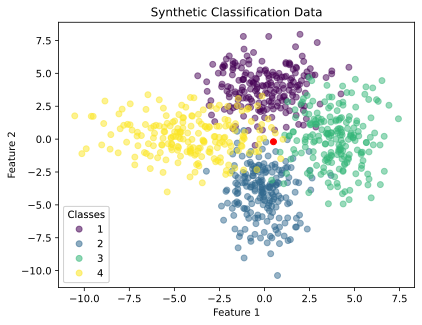

In [2]:
def plot_synthetic_data(ax, X, y, new_point, title):
    ax.set_title(title)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.5)
    ax.scatter(*new_point, c="red")

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


n_samples = 200
n_classes = 4
classes = list(range(1, n_classes + 1))
random_state = 41

# parameters for toy data
means = [(0, 4), (0, -4), (4, 0), (-4, 0)]
covs = [np.eye(2) * 2.5, np.diag([1.5, 3.5]), np.diag([1.5, 4.5]), np.diag([5, 2])]

epsilon = 0.05  # This choice is the central point of conformal prediction

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean, cov, n_samples)
    for mean, cov in zip(means, covs)
])
y = np.hstack([np.full(n_samples, i) for i in classes])

x_q = np.array([0.5, -0.2])

fig, ax = plt.subplots()

plot_synthetic_data(ax, X, y, x_q, "Synthetic Classification Data")

In [3]:
##### Jupyter Book auxiliary########
from myst_nb import glue
glue("synthetic-data",fig, display=False) # makes the  mu abailable in markdown cell with {glue:}`mu`
###################################

```{glue:figure} synthetic-data
:name: "synthetic-data"

Synthetic data created through four Gaussian distributions. A new query point is marked as red dot.
```

<div align="justify">

the basic idea is to hypothetically replace $\bullet$ by each candidate, i.e., to test the hypothesis $y_{N+1} = y$ for all $y \in \mathcal{Y}$. Only those outcomes $y$ for which this hypothesis can be rejected at a predefined level of confidence are excluded, while those for which the hypothesis cannot be rejected are collected to form the prediction set or *prediction region* $Y^\epsilon \subseteq \mathcal{Y}$. The construction of a set-valued prediction $Y^\epsilon = Y^\epsilon(\vec{x}_{n+1})$ that is guaranteed to cover the true outcome $y_{N+1}$ with a given probability $1- \epsilon$ (for example 95 %), instead of producing a point prediction $\hat{y}_{N+1} \in \mathcal{Y}$, is the basic idea of conformal prediction. Here, $\epsilon \in (0,1)$ is a pre-specified level of significance. In the case of classification, $Y^\epsilon$ is a subset of the set of classes $\mathcal{Y} = \{ y_1, \ldots , y_K \}$, whereas in regression, a prediction region is commonly represented in terms of an interval[^regressionCase].

</div>

[^regressionCase]: Obviously, since $\mathcal{Y} = \mathbb{R}$ is infinite in regression, a hypothesis test cannot be conducted explicitly for each candidate outcome $y$. 

<div align="justify">

Hypothesis testing is done in a nonparametric way: Consider any *nonconformity* function $f: \, \mathcal{X} \times \mathcal{Y} \longrightarrow \mathbb{R}$ that assigns a score $\alpha = f(\vec{x}, y)$ to an input/output tuple. The latter can be interpreted as a measure of *strangeness* of the pattern $(\vec{x}, y)$, i.e., the higher the score, the less the data point $(\vec{x}, y)$ conforms to the expected pattern.
```{note}
The error bounds are valid and well calibrated by construction, regardless of the nonconformity function $f$. However, the choice of this function has an important influence on the *efficiency* of conformal prediction, that is, the size of prediction regions: The more suitable the nonconformity function is chosen, the smaller these sets $Y^\epsilon$ will be. 
```

An example of a nonconformity score based on nearest neighbors:

$$
f(\vec{x},y) = \frac{\sum_{i=1}^k d_i^+}{\sum_{i=1}^k d_i^-}
$$

where $d_i^+$ is the distance from the $i^{th}$ nearest neighbor labeled y, and $d_i^-$ the distance from the $i^{th}$ nearest neighbor labeled differently.
Applying this function to the sequence {eq}`cpseq`, with a specific (though hypothetical) choice of $y = y_{N+1}$ (i.e., with $y = 1$), yields a sequence of scores

$$
\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1} \enspace .
$$

</div>

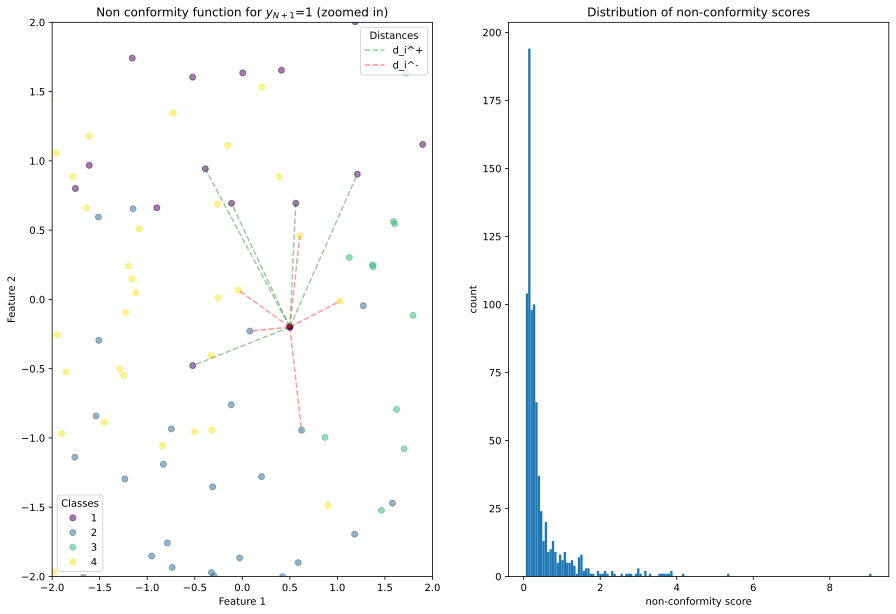

In [30]:
def euclidean_distance(x, data):
    dist = np.linalg.norm(
        x - data, axis=1, ord=2
    )  # L2-norm (euclidean distance between x and all data points in X)
    return dist


def nearest_neighbors_idx(distances, k=5):
    idx = np.argpartition(
        distances, k
    )  # makes the kth element as pivot such that left from it are all smaller elements
    return idx[:k]


def nearest_neighbors_distance(x, data, k=5):
    dist = euclidean_distance(x, data)
    idx = nearest_neighbors_idx(dist, k)
    return dist[idx]  # get the distances of the k nearest neighbors


def split_data_classes(y_i, X, y):
    # create two datasets one where each point has the same class as y_i the other points in the second dataset.
    mask_same_class = y == y_i
    data_with_same_class = X[mask_same_class, :]
    data_with_other_class = X[~mask_same_class, :]
    return data_with_same_class, data_with_other_class


def nearest_neighbors_non_conformity_function(x_i, y_i, X, y):
    data_with_same_class, data_with_other_class = split_data_classes(y_i, X, y)
    distance_to_same_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_same_class, k=5)
    )
    distance_to_other_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_other_class, k=5)
    )

    return distance_to_same_class / distance_to_other_class


def get_nonconformity_scores(x_q, y_new):
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)  # merge X and y into one array
    new_point = np.hstack((x_q, y_new))  # make the new data point
    complete_data = np.vstack((data, new_point))  # put all together

    resulting_scores = np.array(
        [
            nearest_neighbors_non_conformity_function(
                x_i=complete_data[i, :-1],
                y_i=complete_data[i, -1],
                X=np.delete(complete_data, i, axis=0)[:, :-1],
                y=np.delete(complete_data, i, axis=0)[:, -1],
            )
            for i in range(complete_data.shape[0])
        ]
    )

    return resulting_scores


def plot_nearest_neighbors_distance(y_new, ax):
    ax.set_title(r"Non conformity function for $y_{N+1}$" + f"={y_new} (zoomed in)")

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.5)
    ax.scatter(*x_q, c=[1], alpha=1)

    # look up other colors: https://en.wikipedia.org/wiki/X11_color_names
    # visualize the distance to the equally labeled points:
    data_with_same_class, data_with_other_class = split_data_classes(y_new, X, y)
    for i in nearest_neighbors_idx(
            euclidean_distance(x_q, data_with_same_class), k=5
    ):
        x_values = [x_q[0], data_with_same_class[i, 0]]
        y_values = [x_q[1], data_with_same_class[i, 1]]
        (line1,) = ax.plot(
            x_values, y_values, linestyle="--", c="green", label="d_i^+", alpha=0.4
        )

    # visualize the distance to the differently labeled points:
    for i in nearest_neighbors_idx(
            euclidean_distance(x_q, data_with_other_class), k=5
    ):
        x_values = [x_q[0], data_with_other_class[i, 0]]
        y_values = [x_q[1], data_with_other_class[i, 1]]
        (line2,) = ax.plot(
            x_values, y_values, linestyle="--", c="red", label="d_i^-", alpha=0.4
        )

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    # produce a legend with the distance
    ax.legend(handles=[line1, line2], loc="upper right", title="Distances")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


def plot_non_conformity_scores(non_conformity_scores, ax):
    ax.set_title("Distribution of non-conformity scores")

    ax.hist(non_conformity_scores, bins="auto")

    ax.set_xlabel("non-conformity score")
    ax.set_ylabel("count")


alpha_values_y1 = get_nonconformity_scores(x_q=x_q, y_new=1)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((15,10))
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-2, 2])
plot_nearest_neighbors_distance(y_new=1, ax=ax[0])
plot_non_conformity_scores(alpha_values_y1, ax=ax[1])
# plot_nearest_neighbors_distance(y_new=1, ax=ax)
# plot_nearest_neighbors_distance(y_new=2, ax=ax)
# plot_nearest_neighbors_distance(y_new=3, ax=ax)
plt.show()

<div align="justify">

Denote by $\sigma$ the permutation of $\{1, \ldots , N+1\}$ that sorts the scores in increasing order, i.e., such that $\alpha_{\sigma(1)} \leq \ldots \leq \alpha_{\sigma(N+1)}$. Under the assumption that the hypothetical choice of $y_{N+1}$ is in agreement with the true data-generating process, and that this process has the property of exchangeability[^exchangeability] (which assumes that the order of observations is irrelevant), every permutation $\sigma$ has the same probability of occurrence. Consequently, the probability that $\alpha_{N+1}$ is among the $\epsilon$\-\% highest nonconformity scores should be low. This notion can be captured by the $p$-values associated with the candidate $y$, defined as 

$$
p(y)   := \frac{\# \{ i \given \alpha_i \geq \alpha_{N+1} \}}{N+1}
$$(probability_y_highestNonConformity)


</div>

[^exchangeability]: A small example for exchangeability can be found here: {doc}`exchangeability-excursus`.

In [5]:
def calculate_probability(nonconformity_sequence):
    # calculate the proportion that at least new data points nonconformity score occurs.
    new_datapoint_nonconformityScore = nonconformity_sequence[-1]
    probability = np.sum(
        nonconformity_sequence >= new_datapoint_nonconformityScore
    ) / len(
        nonconformity_sequence
    )  # the N + 1 is inherently in the length of the sequence
    return probability


probability_y1 = calculate_probability(alpha_values_y1)
print("Probability of y = 1: ", probability_y1)

Probability of y = 1:  0.03870162297128589


<div align="justify">

According to what we said, the probability that $p(y) < \epsilon$ (i.e., $\alpha_{N+1}$ is among the $\epsilon$\-\% highest $\alpha$-values) is upper-bounded by $\epsilon$. 
Thus, the hypothesis $y_{N+1} = y$ can be rejected for those candidates $y$ for which $p(y) < \epsilon$. 
For the initial choice $y = 1$, we can reject this candidate, because $p(y) \approx 0.038 < 0.05 = \epsilon$.
The complete $Y_\epsilon$ can then be constructed iterating through all possible candidates $y = y_{N+1}$. 

</div>

In [6]:
probabilities = {possible_class: calculate_probability(get_nonconformity_scores(x_q, possible_class))
                 for possible_class in classes}

Y_epsilon = set(
    [
        prediction
        for prediction, probability in probabilities.items()
        if probability >= 0.05
    ]
)
print("Prediction set Y:", Y_epsilon)

Prediction set Y: {2, 4}


<div align="justify">

Conformal prediction as outlined above realizes transductive inference, although inductive variants also exist ({cite:t}`papa_ic08`). For transductive inference the nonconformity scores $\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1}$ have to be re-calculated for each new proposal $y_{N+1}=y$. In inductive inference this problem is solved by using a *calibration* dataset. Many packages have already been published implementing the inductive inference, such as [MAPIE](https://mapie.readthedocs.io/en/latest/index.html). We again use the above-mentioned synthetic dataset and split it into $l$ training and $N-l$ testing points.

</div>

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=random_state)

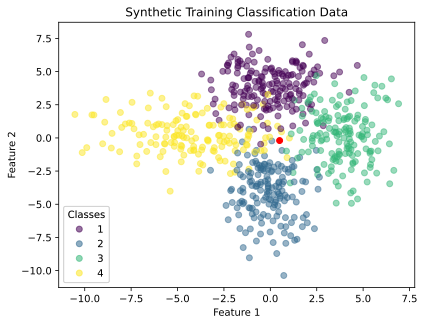

In [8]:
fig, ax = plt.subplots()
# TODO check capitalizations of all your plots (either all capitalized or all only first word capitalized)
plot_synthetic_data(ax, X_train, y_train, x_q, "Synthetic Training Classification Data")
plt.show()

<div align="justify">

In the next step, we take an arbitrary classifier such as the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) and train it on the classification dataset. Then on the validation dataset the corresponding nonconformity scores are computed for which we use the wrapper [MapieClassifier](https://mapie.readthedocs.io/en/latest/generated/mapie.classification.MapieClassifier.html#mapie.classification.MapieClassifier). As a corresponding nonconformity function $f$ we use the *Least Ambiguous Set-Valued Classifier* (LAC) method from {cite:t}`sadi_la19`.

$$
    f(\vec{x},y) = 1 - \hath(\vec{x})_y
$$

where $\hath$ is a classifier and $\hath(\vec{x})_y$ the probability of classifying the data point $\vec{x}$ as $y$. 
Applying this function to the validation dataset yields a sequence of nonconformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$ which is represented by the histogram below.

</div>

```{note}
From an user perspective it is not necessary to split the data into train and validation beforehand. 
The *MapieClassifier* would do this automatically controlled by the parameter `cv`. 
Here, we want to illustrate this, therefore we choose `cv="prefit"`
```

In [9]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

conformal_classifier = MapieClassifier(naive_bayes,
                                       method="lac",
                                       cv="prefit",
                                       random_state=random_state)
conformal_classifier.fit(X_val, y_val)

nonconformity_scores = conformal_classifier.conformity_scores_.flatten()

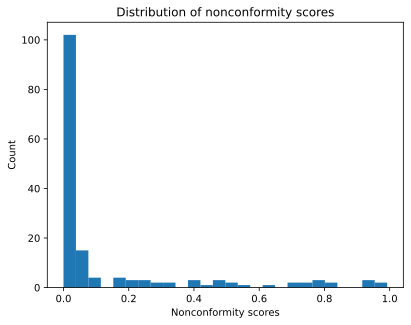

In [10]:
# Plot the score distribution
fig, ax = plt.subplots()
ax.hist(nonconformity_scores, bins="auto")

ax.set_title("Distribution of nonconformity scores")
ax.set_xlabel("Nonconformity scores")
ax.set_ylabel("Count")

plt.show()

<div align="justify">

Given an $\epsilon$ one can define based on the above distribution a threshold $q$ such that all candidates $y_{N+1}=y$ can be rejected if $f(\vec{x}_{N+1},y_{N+1}) \geq q$. The value of $q$ is chosen such that {eq}`probability_y_highestNonConformity` holds. The resulting prediction set is as follows:

$$
    Y^\epsilon = \{
            y \given 1 - \hath(x_{N+1})_y \leq q
        \}
$$

To calculate $q$ one must think of a value such that $(1-\epsilon)$\% of the nonconformity scores $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$ are smaller than $q$. 
This is exactly what the $(1-\epsilon)$ quantile represents!
To find our threshold q, we calculate the $\frac{\lceil (N-l+1)*(1-\epsilon) \rceil}{n}$ quantile on the sequence $\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}$:

$$
    q = \textit{Quantile}\left(\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{N-1}, \alpha_{N}, \frac{\lceil (N-l+1) (1-\epsilon) \rceil}{N-l}\right)
$$ 

We use $(N-l+1)$ instead of $(N-l)$ to take into account the finite sample size.

</div>

In [11]:
# helper function converting the mapie output to a "real" prediction set
def to_prediction_set(prediction_set_indicator):
    n_samples, n_classes, n_alpha = prediction_set_indicator.shape

    prediction_sets_with_zero_fills = prediction_set_indicator * np.array(classes)[None, :, None]

    datapoint_sets = [[]] * n_alpha  # we need so many prediction sets for each data point as we defined alpha values
    prediction_sets = [datapoint_sets] * n_samples
    for sample in range(n_samples):
        for epsilon in range(n_alpha):
            current_mask = (
                    prediction_sets_with_zero_fills[sample, :, epsilon] > 0
            )  # mask to indicate the classes included in set
            prediction_sets[sample][epsilon] = set(prediction_sets_with_zero_fills[
                                                   sample, :, epsilon
                                                   ][
                                                       current_mask
                                                   ])  # put these values in the prediction set
    return prediction_sets

In [12]:
point, prediction_set_indicator = conformal_classifier.predict(
    x_q.reshape(1, -1),
    alpha=[0.05, 0.1],
    # note that what we denote as epsilon is called alpha in MAPIE. Also we can use mutliple epsilon values
)
print("Point estimate: ", point)
print(
    "Prediction Indicator Set(epsilon=0.05; epsilon=0.1): \n", prediction_set_indicator
)  # The output indicates whether the corresponding class is contained in the set prediction set for the given epsilon niveau.
print("Prediction sets (epsilon=.05; epsilon=0.1): \n",
      to_prediction_set(prediction_set_indicator=prediction_set_indicator))

Point estimate:  [2]
Prediction Indicator Set(epsilon=0.05; epsilon=0.1): 
 [[[False False]
  [ True False]
  [False False]
  [ True False]]]
Prediction sets (epsilon=.05; epsilon=0.1): 
 [[{2, 4}, set()]]


To reproduce the above output one can retrace the individual steps. The first step is to obtain the nonconformity scores.

In [13]:
#1. Step: Create nonconformity scores
def get_lac_nonconformity_scores(model, X, y):
    conditional_probabilities = model.predict_proba(X)
    # creates boolean array where True indicates the conditional probability value we need for nonconformity score.
    indices = (np.arange(n_classes) + 1)[None, :] == y[:, None]
    lac_nonconformity_scores = 1 - conditional_probabilities[indices]
    return lac_nonconformity_scores


lac_nonconformity_scores = get_lac_nonconformity_scores(naive_bayes, X_val, y_val)

To reproduce the above output one can retrace the individual steps.
The second step is to calculate the quantile q.

In [14]:
#2. Step: Create Quantile
def calculate_quantile(nonconformity_scores, epsilon):
    return np.quantile(
        nonconformity_scores,
        q=((len(nonconformity_scores) + 1) * (1 - epsilon))
          / len(nonconformity_scores),
        method="higher",  # rounds the quantile to the upper value
    )


# compute the threshold q such that only 5% proportion of the data is bigger than q

q_5percent = calculate_quantile(lac_nonconformity_scores, 0.05)
print("Threshold with epsilon=0.05: ", q_5percent)

q_10percent = calculate_quantile(lac_nonconformity_scores, 0.1)
print("Threshold with epsilon=0.10: ", q_10percent)

Threshold with epsilon=0.05:  0.7831678438712201
Threshold with epsilon=0.10:  0.5646060878125463


As for the next step we calculate the nonconformity scores for the data point $\vec{x}_{N+1}$.

In [15]:
#3.Step: Obtain nonconformity scores for the new_points.
def get_new_points_nonconformity_scores(classifier, new_points):
    # compute nonconformity scores for the new data points
    nonconformity_scores = (1 - classifier.predict_proba(new_points))
    return nonconformity_scores


# compute nonconformity scores for the new data point x_q
nonconformity_scores_x_q = get_new_points_nonconformity_scores(naive_bayes, x_q.reshape(1, -1))

# Output the to 4 decimal places rounded nonconformity scores
for i, score in enumerate(nonconformity_scores_x_q.flatten()):
    print(f"Nonconformity score for y={i + 1}: ", round(score, 4))

Nonconformity score for y=1:  0.9137
Nonconformity score for y=2:  0.5712
Nonconformity score for y=3:  0.9026
Nonconformity score for y=4:  0.6124


In the final step, we construct the $Y^\epsilon$.

In [16]:
prediction_set_5percent = set([
    i + 1 for i, score in enumerate(nonconformity_scores_x_q.flatten()) if score <= q_5percent
])
print("Prediction set for epsilon = 5%: ", prediction_set_5percent)

prediction_set_10percent = set([
    i + 1 for i, score in enumerate(nonconformity_scores_x_q.flatten()) if score <= q_10percent
])
print("Prediction set for epsilon = 10%: ", prediction_set_10percent)
# TODO output should be {} instead of set()

Prediction set for epsilon = 5%:  {2, 4}
Prediction set for epsilon = 10%:  set()


Conformal prediction primarily focuses on constructing valid prediction regions, setting it apart from most other machine learning methods that generate point predictions $y \in \mathcal{Y}$, regardless of whether they include a measure of uncertainty. In a way, conformal prediction takes an orthogonal approach: it specifies the degree of uncertainty (confidence level) beforehand and then adjusts its predictions accordingly, rather than producing predictions first and quantifying uncertainty afterward.

## Uncertainty Quantification in Conformal Prediction
<div align="justify">

Although conformal prediction is mainly concerned with constructing prediction regions, the calculated scores can also be used to quantify uncertainty. In this regard, the notions of *confidence* and *credibility* have been introduced ({cite:t}`gam_pa02`): Let $p_1, \ldots , p_K$ denote the $p$-values that correspond, respectively, to the candidate outcomes $y_1, \ldots , y_K$ in a classification setting.
In the transductive case $p$-values are calculated directly, while they need to be calculated separately in the inductive case. Let us assume an $\epsilon=0.05$.

</div>

In [17]:
def get_p_values(nonconformity_scores_validation, nonconformity_scores_new_point):
    # the +1 is for the score itself which is also part of the nonconformity score sequence in general but not in nonconformity_scores_validation
    return (
        # Sum over all n_validation scores for each data point and each class in nonconformity_scores_newPoint
            (np.sum(nonconformity_scores_validation[:, None, None] >= nonconformity_scores_new_point[None, :, :],
                    axis=0) + 1)
            / (len(nonconformity_scores_validation) + 1)
    )


p_values = get_p_values(
    nonconformity_scores_validation=nonconformity_scores,
    nonconformity_scores_new_point=nonconformity_scores_x_q,
)
for i, p_y in enumerate(p_values.flatten()):
    print(f"The p-value of y = {i + 1} is p(y) = {round(p_y, 3)}.")
    #TODO use Latex

The p-value of y = 1 is p(y) = 0.037.
The p-value of y = 2 is p(y) = 0.099.
The p-value of y = 3 is p(y) = 0.037.
The p-value of y = 4 is p(y) = 0.099.


<div align="justify">

If a single class (point prediction) $\hat{y}$ has to be predicted, it is natural to pick the $y_i$ with the highest $p$-value. The value $p_i$ itself is then a natural measure of credibility, since the larger (closer to 1) this value, the more likely the prediction is correct. 
Note that the value also corresponds to the largest significance level $\epsilon$ for which the prediction region $Y^\epsilon$ would be empty (since all candidates would be rejected). 
In other words, it is a degree to which $y_i$ is indeed a plausible candidate that cannot be excluded.
In our example, we have a low credibility (0.099) indicating that the model has difficulty to correctly classify $x_{N+1}$ given the training points ({cite:t}`papa_ic08`). 
This reasoning is illustrated in the above plot, where it is evident that the point lies close to examples from both class two and class four (see {numref}`synthetic-data`).

</div>

In [18]:
def get_point_prediction_uncertainty(p_values):
    # get for each data point the class with highest p_value. If multiple classes have same p_value we return the first one.
    y_hat = np.argmax(p_values, axis=1) + 1

    sorted_probabilities = np.sort(p_values, axis=1)
    #print(sorted_probabilities)
    credibility, confidence = sorted_probabilities[:, -1], 1 - sorted_probabilities[:, -2]

    return y_hat, credibility, confidence


y_hat, credibility, confidence = get_point_prediction_uncertainty(p_values)
print("Credibility: ", np.round(credibility[0], 3))

Credibility:  0.099


<div align="justify">

Besides credibility one may also inquire to what extent $y_i$ is the unique candidate meaning how definitively other candidates can be excluded.
This can be quantified in terms of the greatest $1 - \epsilon$ for which $Y^\epsilon$ is the singleton set $\{ y_i \}$, that is, $1$ minus the second-highest $p$-value. For our concrete example, we have a high confidence (0.901).
If we look at the p-values, both class two and four have identical ones. Thus, our model can easily disregard class one and three, but has problems with disregarding class four. Because both classes are quite close to the new point this implies aleatoric uncertainty.

</div>

In [19]:
print("Confidence: ", round(confidence[0], 3))

Confidence:  0.901


```{note}
Other methods have been proposed for quantifying uncertainty of a point prediction in the context of conformal prediction ({cite:t}`linu_rc16`).
```

<div align="justify">

To conclude the uncertainty quantification for conformal prediction, we display the credibility and confidence values for all possible data points.
The Naive Bayes model is hereby trained on all synthetic data points (see {numref}`synthetic-data`).

</div>

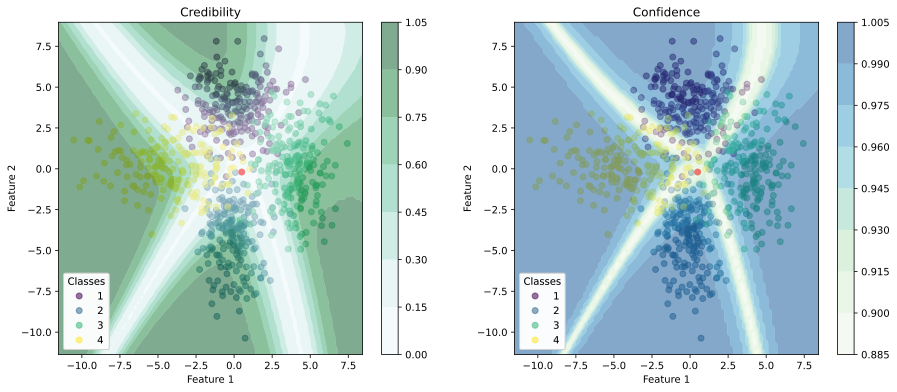

In [20]:
def plot_credibility_contour(ax, X, y, title):
    """Plots a contour plot of the set_sizes induced  by the set_builder.

    Args:
        ax (matplotlib.axes): axes of matplotlib 
        X (np.ndarray): The data points which span the grid for the contour plot.
        y (np.ndarray): The labels of the data points X.
        title (str): The title of the contour plot.
    """

    # create all the points we will calculate the prediction set sizes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x_grid = np.linspace(x_min, x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)

    xv, yv = np.meshgrid(x_grid, y_grid)

    points = np.column_stack((xv.ravel(), yv.ravel()))

    # calculate set sizes
    naive_bayes.fit(X, y)
    nonconform_scores = get_new_points_nonconformity_scores(naive_bayes, points)
    p_values = get_p_values(nonconformity_scores_validation=lac_nonconformity_scores,
                            nonconformity_scores_new_point=nonconform_scores)
    y_hat, confidence, credibility = get_point_prediction_uncertainty(p_values)

    confidence = np.array(confidence).reshape(y_grid.shape[0], x_grid.shape[0])
    credibility = np.array(credibility).reshape(y_grid.shape[0], x_grid.shape[0])

    #print("Set sizes: ", np.unique(set_sizes))

    # plot the data points
    plot_synthetic_data(ax[0], X, y, x_q, title)
    plot_synthetic_data(ax[1], X, y, x_q, title)

    # create contour plot
    cmap = mpl.colormaps["BuGn"]  # define the colormap
    contour = ax[0].contourf(x_grid, y_grid, confidence, cmap=cmap, alpha=.5)

    cmap = mpl.colormaps["GnBu"]  # define the colormap
    contour2 = ax[1].contourf(x_grid, y_grid, credibility, cmap=cmap, alpha=.5)

    ax[0].set_title("Credibility")
    ax[1].set_title("Confidence")

    plt.colorbar(contour, ax=ax[0])
    plt.colorbar(contour2, ax=ax[1])


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_credibility_contour(ax, X, y, "Test")
plt.show()

The following information can be extracted:
- Credibility: The closer the data points are to other class regions, the lower the value becomes. This is intuitive because the probabilities are less distinct in such cases.
- Confidence: This is a similar scenario with a different interpretation: the closer data points are to overlapping class regions, the less likely it is that the prediction will be a singleton set.